In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import PIL.Image as pim
%matplotlib inline

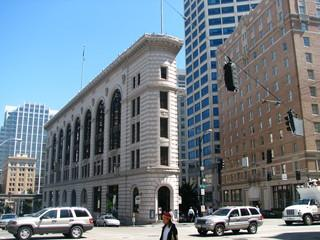

In [3]:
image = pim.open('images/0010950.jpg')
image

In [4]:
image_tensor = torch.Tensor([np.array(image).transpose((2,0,1))])

In [4]:
image_tensor.shape

torch.Size([1, 3, 240, 320])

In [39]:
radius = 3

### Gaussian Kernel  
The weights of this filter sums up to 1. 
So convolving this filter with the original image gives a weighted mean.

In [5]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype='float32')
 
    def gauss(x, y, sigma=2.0):
        Z = 2 * np.pi * sigma ** 2
        return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
    mid = np.floor(kernel_shape[-1] / 2.)
    for kernel_idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
    return x / np.sum(x)

In [6]:
gfilter = torch.Tensor(gaussian_filter((1,3,9,9)))

In [10]:
gfilter.numpy()[0]

array([[[ 0.00025448,  0.00061047,  0.00114051,  0.00165943,  0.00188039,
          0.00165943,  0.00114051,  0.00061047,  0.00025448],
        [ 0.00061047,  0.00146445,  0.00273594,  0.00398078,  0.00451081,
          0.00398078,  0.00273594,  0.00146445,  0.00061047],
        [ 0.00114051,  0.00273594,  0.00511142,  0.00743707,  0.0084273 ,
          0.00743707,  0.00511142,  0.00273594,  0.00114051],
        [ 0.00165943,  0.00398078,  0.00743707,  0.01082087,  0.01226165,
          0.01082087,  0.00743707,  0.00398078,  0.00165943],
        [ 0.00188039,  0.00451081,  0.0084273 ,  0.01226165,  0.01389427,
          0.01226165,  0.0084273 ,  0.00451081,  0.00188039],
        [ 0.00165943,  0.00398078,  0.00743707,  0.01082087,  0.01226165,
          0.01082087,  0.00743707,  0.00398078,  0.00165943],
        [ 0.00114051,  0.00273594,  0.00511142,  0.00743707,  0.0084273 ,
          0.00743707,  0.00511142,  0.00273594,  0.00114051],
        [ 0.00061047,  0.00146445,  0.00273594, 

Applying the Convolution

In [83]:
filtered = F.conv2d(image_tensor,gfilter,padding=8) ## padding = 8 = 9-1 (radius - 1 ) for border == 'full'

In [84]:
filtered.byte().numpy()[0][0].shape

(248, 328)

The filtered output

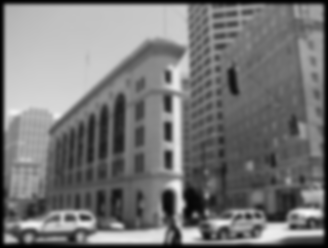

In [10]:
pim.fromarray(filtered.byte().numpy()[0][0])

Removing the padding boundary added

In [13]:
mid = int(np.floor(gfilter.shape[2] / 2.))

In [14]:
filtered[:,:,mid:-mid,mid:-mid].shape

torch.Size([1, 1, 240, 320])

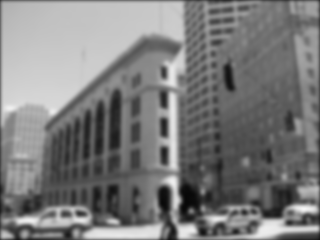

In [15]:
pim.fromarray(filtered[:,:,mid:-mid,mid:-mid].byte().numpy()[0][0])

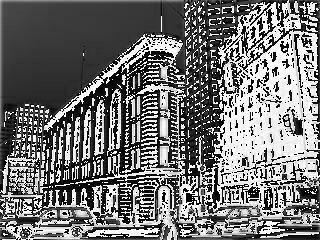

In [104]:
pim.fromarray((image_tensor - filtered[:,:,mid:-mid,mid:-mid]).byte().numpy()[0][2])

### Centered Image
The centered image should have a mean close to 0

In [24]:
centered_image = torch.Tensor([(image_tensor.numpy()[0] - np.array([p]))])

In [192]:
centered_image[0].mean()  ##  mean is close 0 (If we take a finer filter, the mean will tend to 0)

tensor(1.6493)

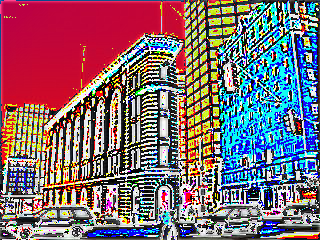

In [105]:
pim.fromarray(centered_image.byte().numpy()[0].transpose((1,2,0)))

In [27]:
sum_sqr_XX = F.conv2d(centered_image.pow(2),gfilter,padding=8)

In [28]:
denom = sum_sqr_XX[:,:,mid:-mid,mid:-mid].sqrt()

In [29]:
denom.shape

torch.Size([1, 1, 240, 320])

In [30]:
per_img_mean = denom.mean()

In [31]:
per_img_mean

tensor(29.5007)

In [106]:
divisor = np.maximum(per_img_mean.numpy(),denom.numpy())

divisor = np.maximum(divisor, 1e-4)

In [34]:
new_image = centered_image / torch.Tensor(divisor)

In [169]:
new_image.byte().shape

torch.Size([1, 3, 240, 320])

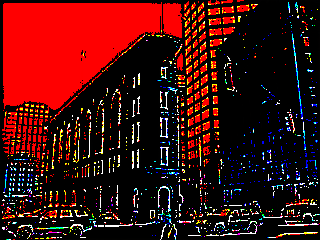

In [70]:
pim.fromarray(new_image.byte().numpy()[0].transpose((1,2,0)))

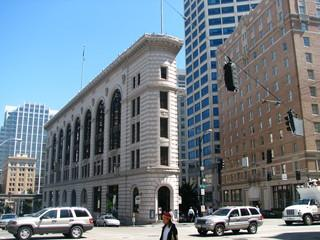

In [71]:
pim.fromarray(image_tensor.byte().numpy()[0].transpose((1,2,0)))

### Putting it all together in a function

In [194]:
def LocalContrastNorm(image,radius=9):
    """
    image: torch.Tensor , .shape => (1,channels,height,width) 
    
    radius: Gaussian filter size (int), odd
    """
    if radius%2 == 0:
        radius += 1
    def get_gaussian_filter(kernel_shape):
        x = np.zeros(kernel_shape, dtype='float64')
 
        def gauss(x, y, sigma=2.0):
            Z = 2 * np.pi * sigma ** 2
            return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
        mid = np.floor(kernel_shape[-1] / 2.)
        for kernel_idx in range(0, kernel_shape[1]):
            for i in range(0, kernel_shape[2]):
                for j in range(0, kernel_shape[3]):
                    x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
        return x / np.sum(x)
    
    n,c,h,w = image.shape[0],image.shape[1],image.shape[2],image.shape[3]

    gaussian_filter = torch.Tensor(get_gaussian_filter((1,c,radius,radius)))
    filtered_out = F.conv2d(image,gaussian_filter,padding=radius-1)
    mid = int(np.floor(gaussian_filter.shape[2] / 2.))
    ### Subtractive Normalization
    centered_image = image_tensor - filtered_out[:,:,mid:-mid,mid:-mid]
    
    ## Variance Calc
    sum_sqr_image = F.conv2d(centered_image.pow(2),gaussian_filter,padding=radius-1)
    s_deviation = sum_sqr_image[:,:,mid:-mid,mid:-mid].sqrt()
    per_img_mean = denom.mean()
    
    ## Divisive Normalization
    divisor = np.maximum(per_img_mean.numpy(),s_deviation.numpy())
    divisor = np.maximum(divisor, 1e-4)
    new_image = centered_image / torch.Tensor(divisor)
    return new_image

In [186]:
ret = LocalContrastNorm(image_tensor,radius=12)

In [187]:
ret.shape

torch.Size([1, 3, 240, 320])

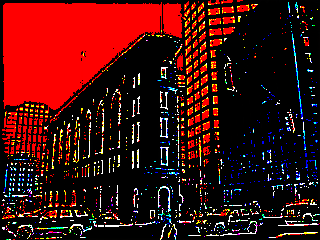

In [188]:
pim.fromarray(ret.byte().numpy()[0].transpose((1,2,0)))